# Group 20 — Clustering

This notebook performs exploratory data analysis on customer and flights databases, covering data inspection, quality assessment, and preprocessing.

## Table of Contents
- [Data Import](#data-import)
- [Data Preprocessing](#preprocessing)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Functions

In [2]:
def winsorize_dataframe(df, columns, limits=(0.01, 0.01)):
    """
    Apply winsorization to each column in `columns`.
    limits=(lower_pct, upper_pct) means: cap values at the 1st and 99th percentile.

    Returns the winsorized copy of df.
    """
    df = df.copy()
    for col in columns:
        if col in df.columns:
            # winsorize returns masked arrays -> convert to normal array
            df[col] = winsorize(df[col], limits=limits).data
    return df

def preprocess_flights(flights_df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply preprocessing steps to the FlightsDB:
    - Winsorize outliers
    - Convert YearMonthDate to datetime
    - Round down NumFlights and NumFlightsWithCompanions
    - Set DistanceKM = 0 where NumFlights == 0
    - Drop DollarCostPointsRedeemed
    - Add log-transformed versions of skewed variables
    - Create PointsUtilizationRatio = PointsRedeemed / PointsAccumulated
    """
    df = flights_df.copy()

    # 0. Winsorize outliers (Flights DB outliers are legitimate but skewed)
    outlier_cols = [
        'NumFlights', 'NumFlightsWithCompanions', 'DistanceKM', 
        'PointsAccumulated', 'PointsRedeemed'
    ]
    df = winsorize_dataframe(df, outlier_cols, limits=(0.01, 0.01))

    # 1. YearMonthDate -> datetime
    if 'YearMonthDate' in df.columns:
        df['YearMonthDate'] = pd.to_datetime(df['YearMonthDate'])

    # 2. Round down flight counts and cast to int
    for col in ['NumFlights', 'NumFlightsWithCompanions']:
        if col in df.columns:
            df[col] = np.floor(df[col]).astype(int)

    # 3. Fix logical inconsistency: DistanceKM must be 0 if NumFlights == 0
    if {'NumFlights', 'DistanceKM'}.issubset(df.columns):
        df.loc[df['NumFlights'] == 0, 'DistanceKM'] = 0

    # 4. Drop perfectly correlated variable
    if 'DollarCostPointsRedeemed' in df.columns:
        df = df.drop(columns=['DollarCostPointsRedeemed'])

    # 5. Log transforms for skewed numeric variables
    log_cols = ['DistanceKM', 'PointsAccumulated', 'PointsRedeemed']
    for col in log_cols:
        if col in df.columns:
            df[f'{col}_log'] = np.log1p(df[col])

    # 6. Points utilisation ratio
    if {'PointsRedeemed', 'PointsAccumulated'}.issubset(df.columns):
        denom = df['PointsAccumulated'].replace({0: np.nan})
        df['PointsUtilizationRatio'] = df['PointsRedeemed'] / denom

    return df

def preprocess_customers(customer_df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply preprocessing steps to the CustomerDB:
    - Create cancellation flag from CancellationDate
    - Group-median imputation (by LoyaltyStatus) for Income and Customer Lifetime Value
    - Winsorize outliers (Income, CLV)
    - Log transform Customer Lifetime Value
    - Create CustomerValueScore composite feature
    """
    df = customer_df.copy()

    # 1. Cancellation flag
    if 'CancellationDate' in df.columns:
        df['CancelledFlag'] = df['CancellationDate'].notna().astype(int)

    # 2. Group-median imputation by LoyaltyStatus
    group_col = 'LoyaltyStatus'
    cols_to_impute = ['Income', 'Customer Lifetime Value']
    for col in cols_to_impute:
        if col in df.columns and group_col in df.columns:
            df[col] = df.groupby(group_col)[col].transform(
                lambda x: x.fillna(x.median())
            )

    # 3. Winsorize outliers
    outlier_cols = ['Income', 'Customer Lifetime Value']
    df = winsorize_dataframe(df, outlier_cols, limits=(0.01, 0.01))

    # 4. Log transform Customer Lifetime Value (for variance stabilisation)
    if 'Customer Lifetime Value' in df.columns:
        df['CustomerLifetimeValue_log'] = np.log1p(df['Customer Lifetime Value'])

    # 5. Customer Value Score (simple composite of CLV and Income)
    clv_col = 'CustomerLifetimeValue_log'
    if clv_col in df.columns:
        clv_scaled = (df[clv_col] - df[clv_col].mean()) / df[clv_col].std(ddof=0)

        if 'Income' in df.columns:
            income_log = np.log1p(df['Income'].clip(lower=0))
            income_scaled = (income_log - income_log.mean()) / income_log.std(ddof=0)
            # Heavier weight on CLV, lighter on Income
            df['CustomerValueScore'] = 0.7 * clv_scaled + 0.3 * income_scaled
        else:
            df['CustomerValueScore'] = clv_scaled
    
    # 6. Education to Years (Ordinal Encoding)
    if 'Education' in df.columns:
        edu_map = {
            'High School or Below': 12,
            'College': 14,
            'Bachelor': 16,
            'Master': 18,
            'Doctor': 21
        }
        df['Education'] = df['Education'].map(edu_map)
        # Fill missing values with mode (Bachelor = 16)
        df['Education'] = df['Education'].fillna(16)

    # 7. Turn marital status into a flag
    if 'Marital Status' in df.columns:
        # Everything value that is not Married should become 1, 0 otherwise
        df['Marital Status'] = np.where(df['Marital Status'] != 'Married', 1, 0)

    return df

def build_customer_flight_features(flights_df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate monthly flight records into customer-level features:
    - TotalFlights, TotalDistanceKM, TotalPointsAccumulated, TotalPointsRedeemed
    - MeanPointsUtilization
    - AverageFlightDistance
    """
    id_col = 'Loyalty#'
    df = flights_df.copy()

    agg = (
        df
        .groupby(id_col)
        .agg(
            TotalFlights=('NumFlights', 'sum'),
            TotalDistanceKM=('DistanceKM', 'sum'),
            TotalPointsAccumulated=('PointsAccumulated', 'sum'),
            TotalPointsRedeemed=('PointsRedeemed', 'sum'),
            MeanPointsUtilization=('PointsUtilizationRatio', 'mean')
        )
        .reset_index()
    )

    # Average flight distance = total distance / total flights
    agg['AverageFlightDistance'] = agg['TotalDistanceKM'] / agg['TotalFlights'].replace({0: np.nan})

    return agg

def create_model_df(customer_df: pd.DataFrame, flights_df: pd.DataFrame) -> pd.DataFrame:
    """
    Orchestrates the creation of the final modeling dataframe:
    1. Preprocess customers and flights
    2. Build customer-level flight features
    3. Merge datasets (Left Join)
    4. Set Loyalty# as Index
    5. Handle missing values
    6. Calculate FlightActivityScore (on full dataset)
    7. Encode categorical variables (OneHotEncoder)
    8. Drop unnecessary columns (IDs, Location strings)
    9. Scale numeric features (StandardScaler) - Excluding CancelledFlag
    """
    # 1. Preprocess
    cust_clean = preprocess_customers(customer_df)
    flights_clean = preprocess_flights(flights_df)

    # 2. Build flight features
    flight_features = build_customer_flight_features(flights_clean)

    # 3. Merge (Left join to keep customers with 0 flights)
    model_df = cust_clean.merge(flight_features, on='Loyalty#', how='left')

    # 4. Set Loyalty# as Index
    if 'Loyalty#' in model_df.columns:
        model_df.set_index('Loyalty#', inplace=True)

    # 5. Handle Missing Values (Numeric)
    flight_cols = [
        'TotalFlights', 'TotalDistanceKM', 'TotalPointsAccumulated',
        'TotalPointsRedeemed', 'MeanPointsUtilization', 'AverageFlightDistance'
    ]
    for col in flight_cols:
        if col in model_df.columns:
            model_df[col] = model_df[col].fillna(0)

    # 6. Calculate FlightActivityScore (combines total flights and distance z-scores)
    # We calculate this AFTER merge and fillna so that 0-flight customers are included in the distribution
    for col in ['TotalFlights', 'TotalDistanceKM']:
        if col in model_df.columns:
            mean = model_df[col].mean()
            std = model_df[col].std(ddof=0)
            if std == 0:
                model_df[f'{col}_z'] = 0
            else:
                model_df[f'{col}_z'] = (model_df[col] - mean) / std
    
    if 'TotalFlights_z' in model_df.columns and 'TotalDistanceKM_z' in model_df.columns:
        model_df['FlightActivityScore'] = model_df['TotalFlights_z'] + model_df['TotalDistanceKM_z']
    else:
        model_df['FlightActivityScore'] = 0

    # 7. Drop unnecessary columns
    cols_to_drop = [
        'First Name', 'Last Name', 'CancellationDate',
        'Country', 'Province or State', 'City', 'Postal Code',
        'Latitude', 'Longitude',

        # Dropped due to engineered features
        'TotalFlights', 'TotalDistanceKM', 'TotalPointsAccumulated',
        'Customer Lifetime Value', 'Income',
        'TotalFlights_z', 'TotalDistanceKM_z','CustomerLifetimeValue_log'
    ]
    model_df = model_df.drop(columns=[c for c in cols_to_drop if c in model_df.columns], errors='ignore')

    # 6. Separate Numeric and Categorical
    categorical_cols = ['LoyaltyStatus', 'Location Code']
    categorical_cols = [c for c in categorical_cols if c in model_df.columns]
       
    numeric_cols = model_df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Exclude CancelledFlag from scaling (Loyalty# is already index)
    unscaled_cols = []
    for col in ['CancelledFlag', 'Marital Status']:
        if col in numeric_cols:
            numeric_cols.remove(col)
            unscaled_cols.append(col)

    # 9. OneHotEncoding
    ohe = OneHotEncoder(sparse_output=False, drop='first', dtype=int)
    encoded_data = ohe.fit_transform(model_df[categorical_cols])
    encoded_cols = ohe.get_feature_names_out(categorical_cols)
    
    df_encoded = pd.DataFrame(encoded_data, columns=encoded_cols, index=model_df.index)
    
    # 10. Scale Numeric Features
    scaler = StandardScaler()
    scaled_numeric = scaler.fit_transform(model_df[numeric_cols])
    df_numeric_scaled = pd.DataFrame(scaled_numeric, columns=numeric_cols, index=model_df.index)
    
    # 11. Combine Scaled Numeric, Unscaled (Binary/ID), and OHE Categorical
    dfs_to_concat = [df_numeric_scaled, df_encoded]
    if unscaled_cols:
        dfs_to_concat.append(model_df[unscaled_cols])
        
    df_final = pd.concat(dfs_to_concat, axis=1)
    
    return df_final

# <a id="data-import"></a> Data Import

In [3]:
# Load the data
customer_db = pd.read_csv("data/DM_AIAI_CustomerDB.csv", index_col=0 )
flights_db = pd.read_csv("data/DM_AIAI_FlightsDB.csv")

# <a id="preprocessing"></a> Data Preprocessing

In this section we apply the preprocessing and feature engineering steps
described in the report:

- Fix data types and logical inconsistencies in **FlightsDB**
- Handle missing values and transform skewed variables in **CustomerDB**
- Create new features: log-transformed variables, points utilisation,
  cancellation flag, customer value score, flight activity score, and
  average flight distance.



In [4]:
# Remove duplicates in customer database
initial_rows = customer_db.shape[0]
duplicated_loyalty_ids = customer_db[customer_db['Loyalty#'].duplicated()]['Loyalty#'].unique()
customer_db = customer_db.drop_duplicates(subset=['Loyalty#'])
dropped_rows = initial_rows - customer_db.shape[0]
dropped_percentage = (dropped_rows / initial_rows) * 100

print(f"Dropped {dropped_rows} duplicate customers ({dropped_percentage:.2f}%).")
# Note: We do not filter flights_db here because the inner join later will automatically exclude flights from dropped customers.

Dropped 164 duplicate customers (0.97%).


In [5]:
# Create the modeling dataset using the pipeline function
# This handles preprocessing, merging, missing values, encoding, feature selection AND scaling
model_df = create_model_df(customer_db, flights_db)


model_df.head()

,Education,CustomerValueScore,TotalPointsRedeemed,MeanPointsUtilization,AverageFlightDistance,FlightActivityScore,LoyaltyStatus_Nova,LoyaltyStatus_Star,Location Code_Suburban,Location Code_Urban,CancelledFlag,Marital Status
Loyalty#,,,,,,,,,,,,
480934,0.247015,-0.427286,0.608273,-0.246381,0.592418,0.919588,0,1,0,1,0,0
549612,-0.946877,-1.352050,1.161426,0.405034,-0.431266,1.224557,0,1,0,0,0,1
429460,-0.946877,-1.351999,-0.332591,0.224053,-0.101999,-0.362237,0,1,0,1,1,1
608370,-0.946877,-1.351999,0.956359,0.378357,0.032897,0.634331,0,1,1,0,0,1
530508,0.247015,-0.398379,-0.983437,-0.429428,0.130452,0.392592,0,1,1,0,0,0


In [6]:
# Check for missing values in the model dataframe
model_df.isnull().sum()


Education                 0
CustomerValueScore        0
TotalPointsRedeemed       0
MeanPointsUtilization     0
AverageFlightDistance     0
FlightActivityScore       0
LoyaltyStatus_Nova        0
LoyaltyStatus_Star        0
Location Code_Suburban    0
Location Code_Urban       0
CancelledFlag             0
Marital Status            0
dtype: int64

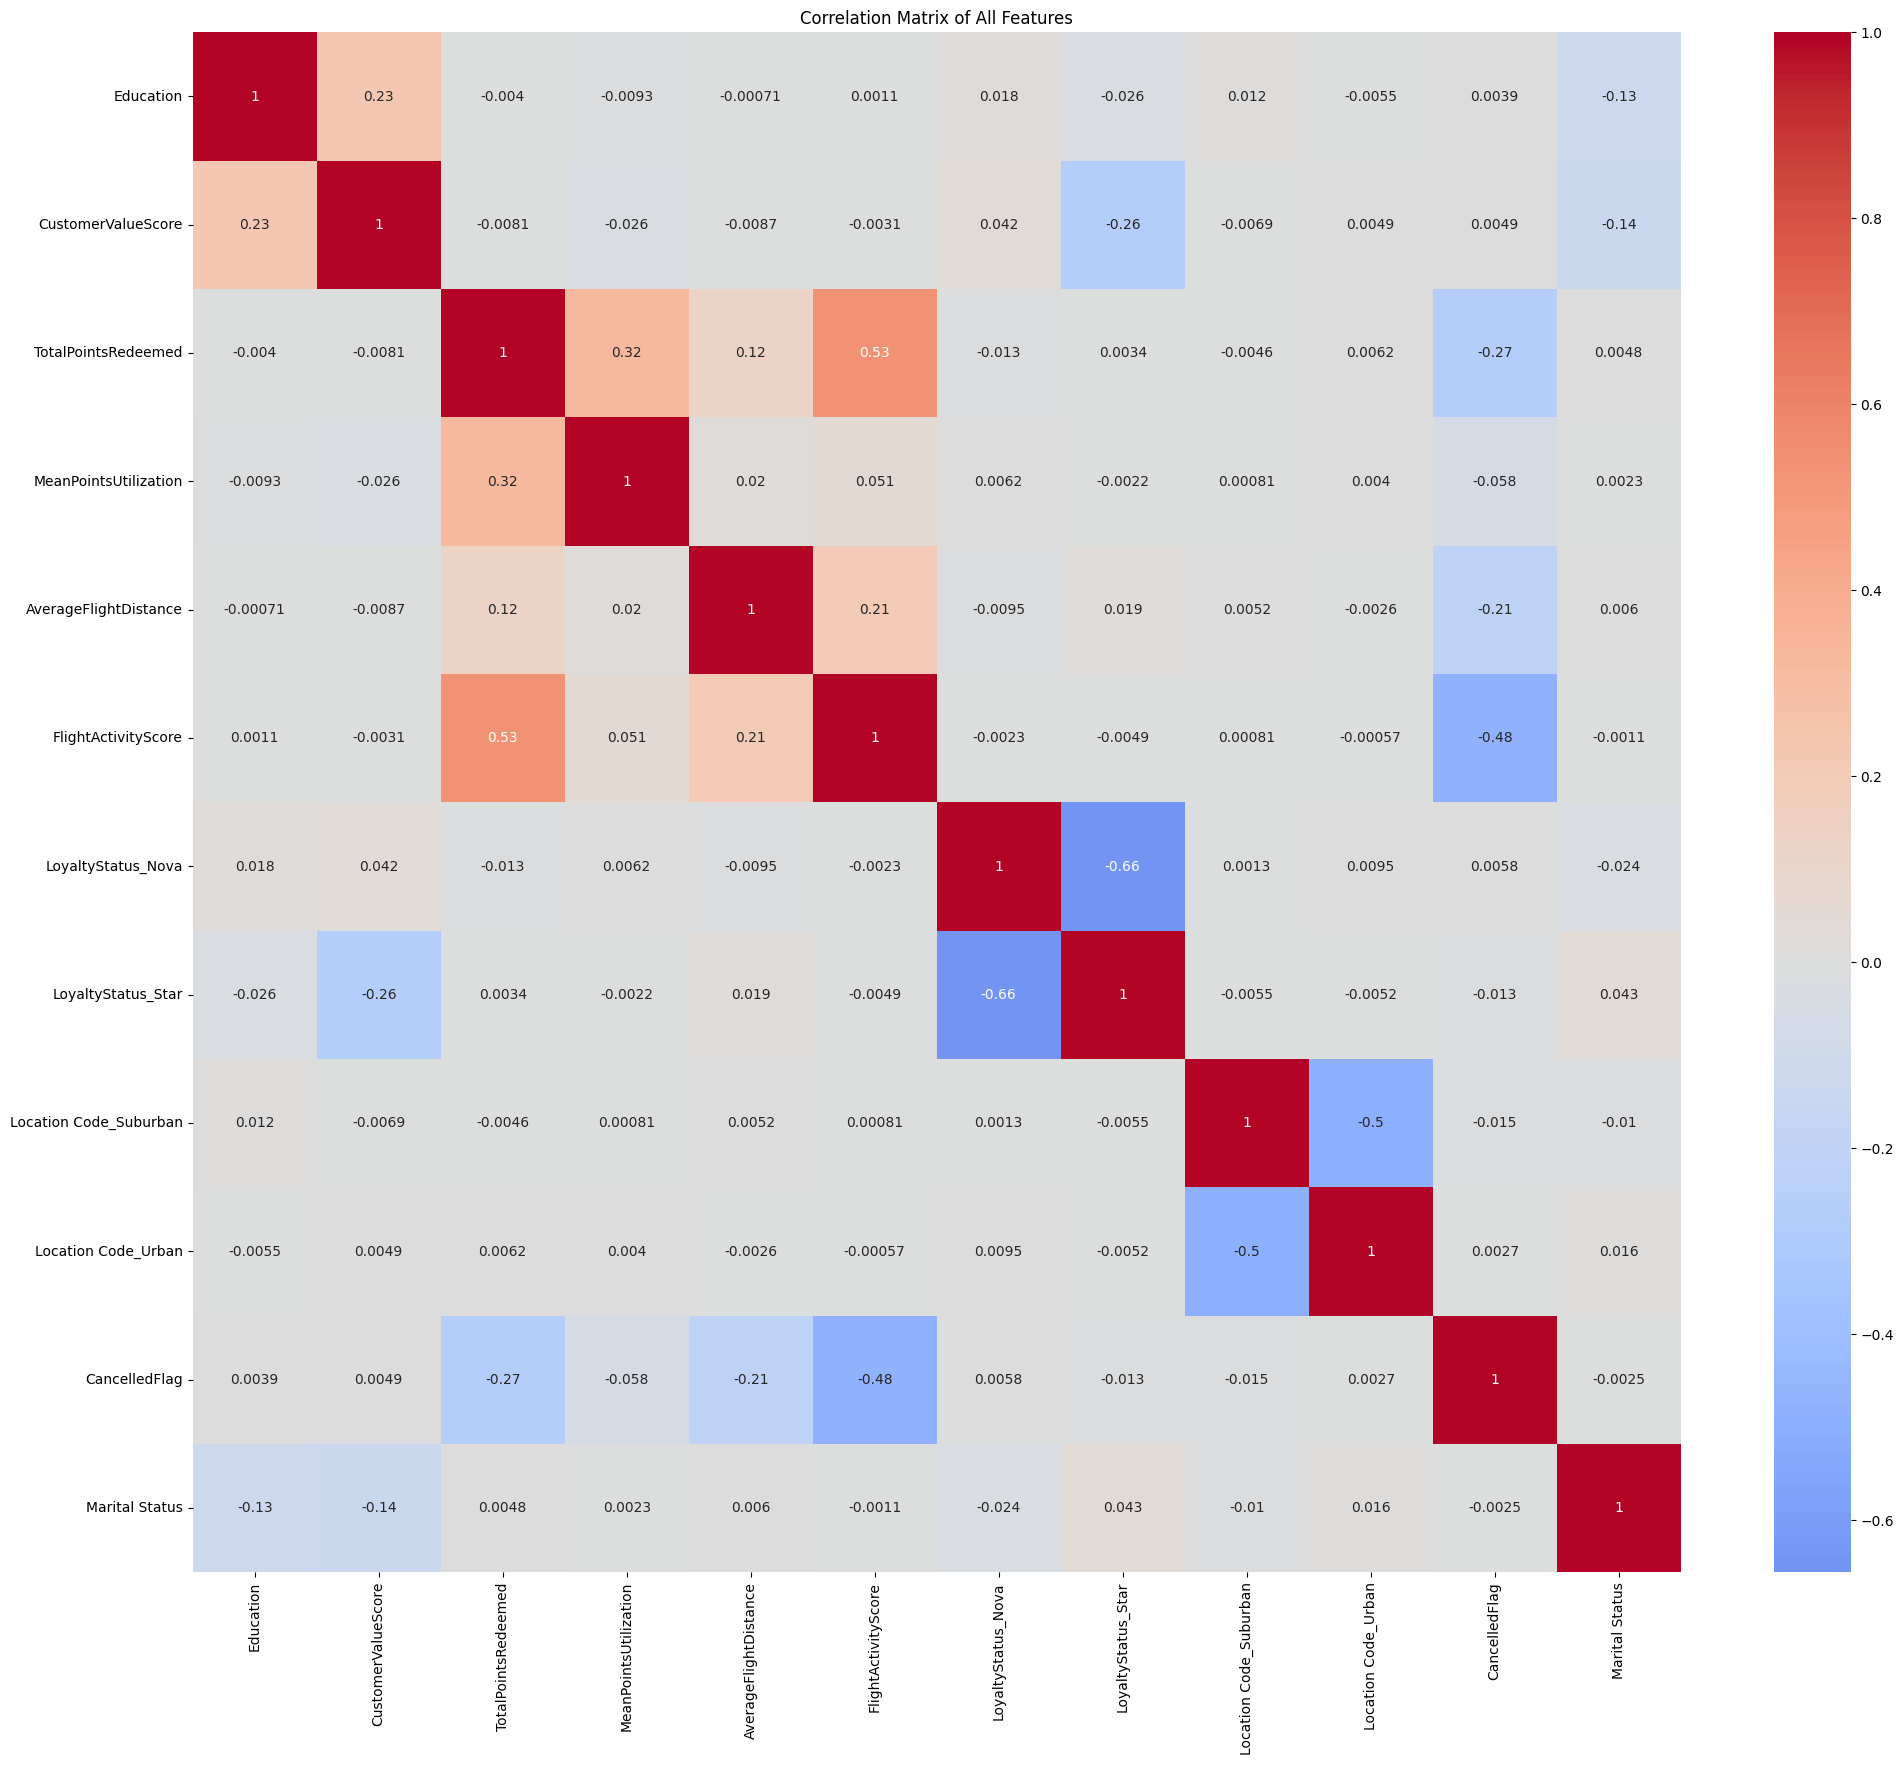

In [7]:
# Plot correlation matrix of the model dataframe
plt.figure(figsize=(24, 20))
corr_matrix = model_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of All Features')
plt.show()

# DBSCAN 


To identify anomalous customer behavior, the DBSCAN algorithm was applied to the scaled feature space. In this project, DBSCAN is used exclusively for outlier detection, not for final customer segmentation.

In [8]:
# Use model_df as X_scaled (Loyalty# is now the index)
X_scaled = model_df
dbscan = DBSCAN(eps=1.9, min_samples=20, n_jobs=1)
dbscan_labels = dbscan.fit_predict(X_scaled)

outlier_count = Counter(dbscan_labels)
print(f"DBSCAN results: {outlier_count}")
print(f"Outliers detected: {outlier_count.get(-1, 0)}")
print(f"Core customers: {outlier_count.get(0, 0)}")

DBSCAN results: Counter({np.int64(0): 16513, np.int64(-1): 244})
Outliers detected: 244
Core customers: 16513


The algorithm identified multiple dense regions in the data, reflecting local behavioral patterns across customers. A small fraction of observations was classified as noise.

In [9]:
core_mask = (dbscan_labels != -1)

X_scaled = X_scaled[core_mask]

print(f"Core customers kept: {len(X_scaled):,}")


Core customers kept: 16,513


DBSCAN successfully identified a small proportion of anomalous customers (~5%), while preserving the vast majority of the dataset for subsequent analysis. This confirms that most customers exhibit consistent behavior, and that outliers can be safely removed to improve the robustness of downstream clustering and modeling tasks.

## Clustering

In [10]:
inertias = []
silhouettes = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(
        n_clusters=k,
        init='k-means++',
        random_state=42,
        n_init=20
    )
    labels = kmeans.fit_predict(X_scaled)

    inertias.append(kmeans.inertia_)
    sil = silhouette_score(X_scaled, labels)
    silhouettes.append(sil)

    print(f"For n_clusters = {k}, the average silhouette_score is : {sil}")


For n_clusters = 2, the average silhouette_score is : 0.19226557551758958
For n_clusters = 3, the average silhouette_score is : 0.1530139769678167
For n_clusters = 4, the average silhouette_score is : 0.14862850825118712
For n_clusters = 5, the average silhouette_score is : 0.15677864703382338
For n_clusters = 6, the average silhouette_score is : 0.15201120032158846
For n_clusters = 7, the average silhouette_score is : 0.13313168253240726
For n_clusters = 8, the average silhouette_score is : 0.140129190902289
For n_clusters = 9, the average silhouette_score is : 0.1388156159463833
For n_clusters = 10, the average silhouette_score is : 0.13259939445414462


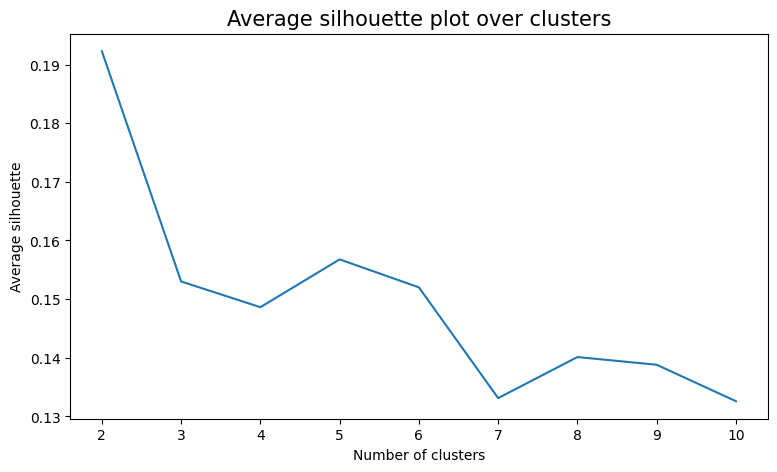

In [11]:
plt.figure(figsize=(9,5))

plt.plot(list(K), silhouettes)

plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()